Imports

In [ ]:
import tensorflow as tf
import os
from google.colab import drive

import zipfile

import re
import numpy as np
import pandas as pd

from keras import backend as K

import math
import matplotlib.pyplot as plt

import pandas as pd

google_drive_mount_path = '/content/gdrive'
google_drive_shared_path = os.path.join(google_drive_mount_path, 'My Drive' , 'Thesis/')

from google.colab import drive
drive.mount(google_drive_mount_path)

import matplotlib.image as mpimg
from PIL import Image, ImageDraw
from tensorflow.keras.preprocessing import image
from tqdm import tqdm_notebook as tqdm

#Data pre-processing

In [ ]:
X_train = np.load(os.path.join('/content/gdrive', 'My Drive' , 'Thesis' , 'Data' , 'kaggle data np','X_train.npy'))
X_val = np.load(os.path.join('/content/gdrive', 'My Drive' , 'Thesis' , 'Data' , 'kaggle data np','X_val.npy'))

y_train = np.load(os.path.join('/content/gdrive', 'My Drive' , 'Thesis' , 'Data' , 'kaggle data np','Y_train.npy'))
y_val = np.load(os.path.join('/content/gdrive', 'My Drive' , 'Thesis' , 'Data' , 'kaggle data np','Y_test.npy'))

##Imbalanced classes

In [ ]:
from collections import Counter
Counter(y_train) , Counter(y_val)

(Counter({0: 26031, 1: 469}), Counter({0: 6511, 1: 115}))

In [ ]:
Y_train = tf.keras.utils.to_categorical(y_train,2)
Y_val = tf.keras.utils.to_categorical(y_val,2)

##Class weights

In [ ]:
SAMPLES_PER_CLASSES_TRAINING = dict(Counter(y_train))

weight_for_0 = (1 / SAMPLES_PER_CLASSES_TRAINING[0])*(sum(SAMPLES_PER_CLASSES_TRAINING.values()))/2.0 
weight_for_1 = (1 / SAMPLES_PER_CLASSES_TRAINING[1])*(sum(SAMPLES_PER_CLASSES_TRAINING.values()))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.5090084898774537, 1: 28.251599147121535}

##Augmentation

In [ ]:
def data_augment(image, label):


    image = tf.image.random_crop(image,size=[224,224,3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, lower = 0, upper = 3)

    return image, label   

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.map(data_augment).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

##Resampling

In [ ]:
negative_ds = (
  train_dataset
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  train_dataset
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(BATCH_SIZE)

#Model

##Architecture

In [ ]:
IMAGE_SIZE = [224,224]

pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False # tramsfer learning


output = tf.keras.layers.Flatten()(pretrained_model.output)
output = tf.keras.layers.Dense(units = 256, activation='relu',)(output) 
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.9)(output)
output = tf.keras.layers.Dense(2 ,activation='softmax')(output)

model_vgg16 = tf.keras.Model(pretrained_model.input, output)

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
#model.compile(optimizer=opt, loss= tf.keras.losses.BinaryCrossentropy() , metrics=['accuracy'])
model_vgg16.compile(#loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.AUC()])
              #metrics=['accuracy', tf.keras.metrics.AUC()])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##Training

In [ ]:
history = model_vgg16.fit(train_dataset, epochs=100, class_weight=class_weight,validation_data=test_dataset)

Epoch 1/100
415/415 [==============================] - 101s 244ms/step - loss: 1.0703 - accuracy: 0.5897 - auc: 0.6115 - val_loss: 0.4208 - val_accuracy: 0.8236 - val_auc: 0.8999
Epoch 2/100
415/415 [==============================] - 96s 231ms/step - loss: 0.7265 - accuracy: 0.6708 - auc: 0.7133 - val_loss: 0.2717 - val_accuracy: 0.9345 - val_auc: 0.9797
Epoch 3/100
415/415 [==============================] - 96s 231ms/step - loss: 0.6174 - accuracy: 0.7058 - auc: 0.7527 - val_loss: 0.4077 - val_accuracy: 0.8560 - val_auc: 0.9254
Epoch 4/100
415/415 [==============================] - 95s 230ms/step - loss: 0.5826 - accuracy: 0.7289 - auc: 0.7746 - val_loss: 0.3583 - val_accuracy: 0.8826 - val_auc: 0.9483
Epoch 5/100
415/415 [==============================] - 95s 230ms/step - loss: 0.5826 - accuracy: 0.7269 - auc: 0.7748 - val_loss: 0.4288 - val_accuracy: 0.8284 - val_auc: 0.9030
Epoch 6/100
415/415 [==============================] - 95s 230ms/step - loss: 0.5485 - accuracy: 0.7468 - auc

In [ ]:
model_vgg16.save('gdrive/My Drive/Thesis/models/model_aws.h5')

##Evaluation

###Loss & Accuracy

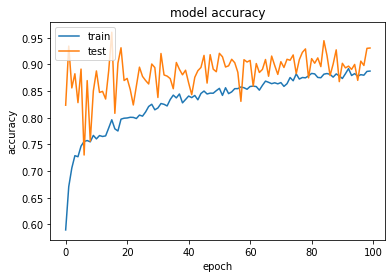

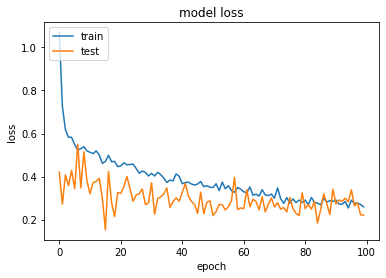

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('gdrive/My Drive/Thesis/models/acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('gdrive/My Drive/Thesis/models/loss.png')
plt.show()

###AUC metric

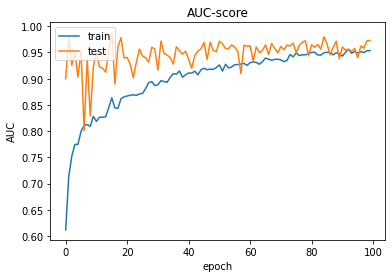

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC-score')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('gdrive/My Drive/Thesis/models/auc.png')
plt.show()